# Melanoma Image classifier using CNN
The following model aims to create an image classifier to detect benign and malign skin melanoma using Convulotional Neural Networks.

- Data Source : https://www.kaggle.com/datasets/hasnainjaved/melanoma-skin-cancer-dataset-of-10000-images

*Author : Roberto Daniel Totolici*

In [1]:
import pandas as pd
import numpy as np
import os
import cv2
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
import matplotlib.pyplot as plt

2024-03-27 07:37:07.008140: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Data Extraction

In [2]:
train_benign_dir = '/home/psykoss/Documents/DataScience/ML/Melanoma_CNN/dataset/train/Benign'
train_malign_dir = '/home/psykoss/Documents/DataScience/ML/Melanoma_CNN/dataset/train/Malignant'
test_benign_dir = '/home/psykoss/Documents/DataScience/ML/Melanoma_CNN/dataset/test/Benign'
test_malign_dir = '/home/psykoss/Documents/DataScience/ML/Melanoma_CNN/dataset/test/Malignant'

In [3]:
def load_image(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename))
        if img is not None:
            images.append(img)
    return images

# Data preparation

We prepare our data by: 
- Loading the images
- Labelling them
- Merge them

In [4]:
#Load Images , training and test sets
X_train_benign = load_image(train_benign_dir)
X_train_malign = load_image(train_malign_dir)

X_test_benign = load_image(test_benign_dir)
X_test_malign = load_image(test_malign_dir)

In [5]:
#Vectorize unitarly benign and malign examples for binary classification
y_train_benign = np.zeros(len(X_train_benign))
y_train_malign = np.ones(len(X_train_malign))

y_test_benign = np.zeros(len(X_test_benign))
y_test_malign = np.ones(len(X_test_malign))

In [6]:
#Merge Train and Test Sets 
X_train = np.array(X_train_benign + X_train_malign)
y_train = np.concatenate([y_train_benign, y_train_malign])

X_test = np.array(X_test_benign + X_test_malign)
y_test = np.concatenate([y_test_benign, y_test_malign])

In [7]:
#Check shapes
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(11879, 224, 224, 3)
(11879,)
(2000, 224, 224, 3)
(2000,)


In [8]:
#Categorize into two levels the binary classes
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

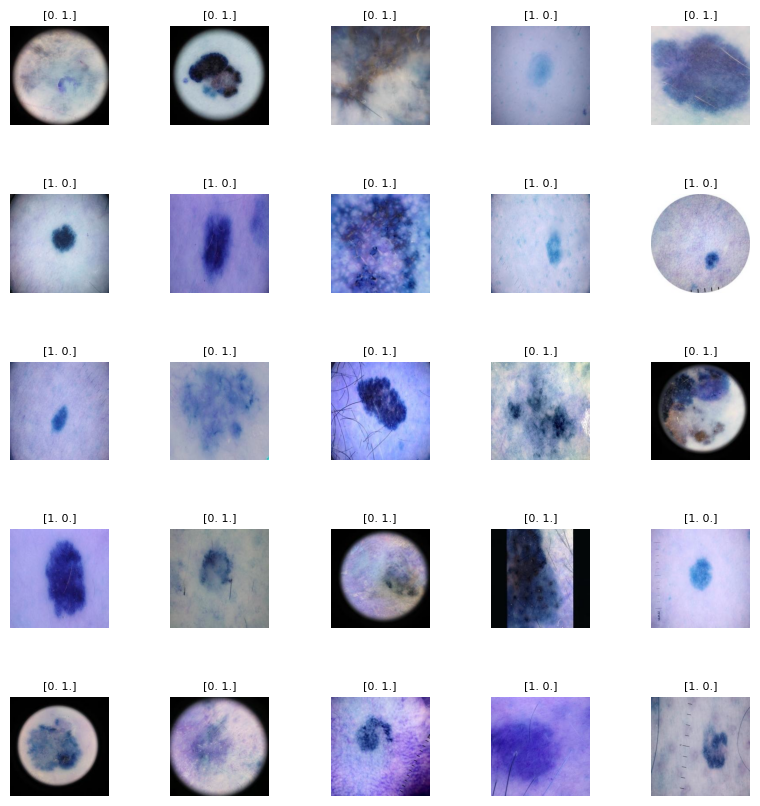

In [11]:
#Create a function to plot images
def show_images(grid_size, X_train,y_train):
    
    fig, axes = plt.subplots(grid_size, grid_size, figsize = (10,10))
    axes = axes.ravel()
    data_len = len(X_train)
    
    for i in np.arange(0, grid_size * grid_size):
        index = np.random.randint(0, data_len)
        
        axes[i].imshow(X_train[index])
        axes[i].set_title(y_train[index],fontsize = 8)
        axes[i].axis('off')
    plt.subplots_adjust(hspace=0.7)

show_images(5,X_train,y_train)

# Data Split and shuffling

In [12]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state = 42)

X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size = 0.2, random_state=42)

In [14]:
from sklearn.utils import shuffle

X_train, y_train = shuffle(X_train, y_train)

# Image Preprocessing

We will reduce the input channel to 1 and normalize the images

In [15]:
#Normalizing the images
X_train_gray = np.sum(X_train/3, axis = 3, keepdims = True)
X_test_gray = np.sum(X_test/3,  axis = 3, keepdims = True)
X_val_gray = np.sum(X_val/3, axis= 3, keepdims = True)

X_train_gray_norm = (X_train_gray - 128) / 128
X_test_gray_norm = (X_test_gray - 128) / 128
X_val_gray_norm = (X_val_gray - 128) / 128

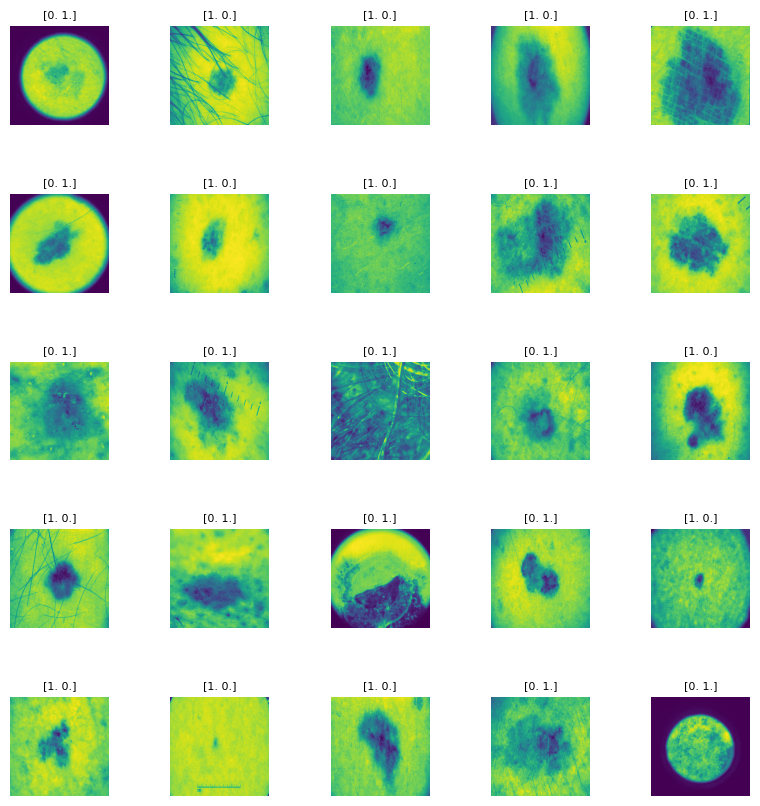

In [16]:
show_images(5,X_train_gray_norm,y_train)

# CNN model

The following model architecture is composed by: 

- 3 convolutions followed by Max Pooling (32,64,128, reLu)
- 3 Dropouts
- 1 Fully connected dense layer (512 outputs, sigmoid)
- 1 L2 regularizer
- 1 output layer (2 outputs, softmax)
- Early stopping
- Learning rate reducer

Optimized with : 
- Adam Optimizer
- Binary Cross Entropy

Trained on:
- 8 epochs

In [1]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Convolution2D, MaxPooling2D
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras import utils
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras import regularizers


input_shape = (224,224,1)

model = Sequential([
    Convolution2D(32, kernel_size = (3,3), activation = 'relu', padding = 'same', input_shape = input_shape),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.25),
    
    Convolution2D(64, kernel_size=(3,3), activation='relu', padding= 'same'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.25),

    Convolution2D(128, kernel_size=(3,3), activation='relu', padding= 'same'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.25),
    
    Flatten(),
    
    Dense(512,activation='relu',kernel_regularizer = regularizers.l2(0.01)),
    Dense(2,activation='softmax')
])

early_stopping = EarlyStopping(patience=6)
checkpoint = ModelCheckpoint('checkpoint1.keras', monitor = 'accuracy', verbose = 1,
                            save_best_only = True, mode = 'auto')

reduce_lr = ReduceLROnPlateau(monitor = 'accuracy', factor = 0.2 , patience=10, min_lr = 0.0001, verbose = 1)
tensorboard_visualization = TensorBoard(log_dir = 'logs')

2024-03-27 13:33:51.025916: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-27 13:33:53.811985: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [18]:
model.compile(loss = 'binary_crossentropy',
             optimizer ='adam',
             metrics = ['accuracy'])

In [19]:
history = model.fit(X_train_gray_norm, y_train,
                   batch_size=32, epochs = 8,
                   verbose = 1,
                   callbacks = [early_stopping, checkpoint, reduce_lr, tensorboard_visualization],
                   validation_data = (X_val_gray_norm, y_val))

Epoch 1/8
238/238 [==============================] - ETA: 0s - loss: 0.9877 - accuracy: 0.7410
Epoch 1: accuracy improved from -inf to 0.74099, saving model to checkpoint1.keras
238/238 [==============================] - 308s 1s/step - loss: 0.9877 - accuracy: 0.7410 - val_loss: 0.5259 - val_accuracy: 0.7837 - lr: 0.0010
Epoch 2/8
238/238 [==============================] - ETA: 0s - loss: 0.5322 - accuracy: 0.7669
Epoch 2: accuracy improved from 0.74099 to 0.76690, saving model to checkpoint1.keras
238/238 [==============================] - 296s 1s/step - loss: 0.5322 - accuracy: 0.7669 - val_loss: 0.5801 - val_accuracy: 0.7222 - lr: 0.0010
Epoch 3/8
238/238 [==============================] - ETA: 0s - loss: 0.5258 - accuracy: 0.7719
Epoch 3: accuracy improved from 0.76690 to 0.77190, saving model to checkpoint1.keras
238/238 [==============================] - 296s 1s/step - loss: 0.5258 - accuracy: 0.7719 - val_loss: 0.5058 - val_accuracy: 0.7753 - lr: 0.0010
Epoch 4/8
238/238 [======

In [20]:
test_loss,test_accuracy = model.evaluate(X_test_gray_norm, y_test)

60/60 [==============================] - 14s 233ms/step - loss: 0.4378 - accuracy: 0.8375


Our test yields 83.75% accuracy

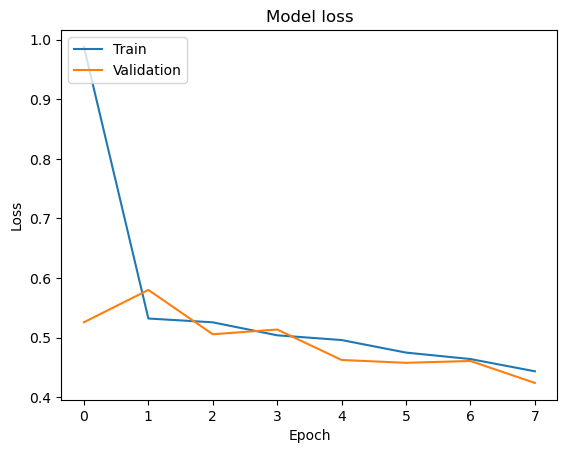

In [21]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [29]:
history_dict = history.history
history_df = pd.DataFrame(history_dict)
print(history_df)

       loss  accuracy  val_loss  val_accuracy     lr
0  0.987653  0.740989  0.525936      0.783670  0.001
1  0.532212  0.766903  0.580079      0.722222  0.001
2  0.525804  0.771902  0.505796      0.775253  0.001
3  0.504028  0.778874  0.513739      0.804293  0.001
4  0.496077  0.808208  0.462663      0.827862  0.001
5  0.475050  0.820968  0.457905      0.847643  0.001
6  0.464234  0.831623  0.460989      0.830808  0.001
7  0.443682  0.833991  0.424181      0.852694  0.001


We achieved an accuracy of 83% and it seems that our model is fitting the image classification very well, the training and validation loss converge at the same time.

### Improvements 

- We could use a prebuilt architecture e.g a resnet
- Try different kernel sizes
- Image augmentation
- Train longer

### Conclusion

The following model provides a reasonable solution to classify 224x224 melanoma images although it is not recommended to rely on these results.